In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline, TransformerMixin
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [7]:
test = pd.read_csv("test.csv", index_col = 0)
train = pd.read_csv('train.csv', index_col = 0)
train.shape

(1460, 80)

In [118]:
X_train, y_train = train.drop("SalePrice", axis = 1), train["SalePrice"]

Удалим малоинформативные признаки

In [10]:
X_train.drop([ 'PoolQC', 'MiscFeature', 'Alley', 'LandSlope',
              'Condition2', 'RoofMatl', 'Heating',
              'Electrical', 'Functional', 'GarageCond',
              'PavedDrive', 'MiscVal', 'PoolArea', 'ScreenPorch'],
             axis = 1, inplace = True)

Получим списки признаков по типу данных

In [11]:
categorical_cols = [x for x in X_train.columns if X_train[x].dtype == object]
numeric_cols = [x for x in X_train.columns if x not in categorical_cols]

Сначала построим отдельно по модели для категориальных и численных признаков

In [67]:
X_numeric = X_train[numeric_cols]
X_categorical = X_train[categorical_cols]

test_num = test[numeric_cols]
test_cat = test[categorical_cols]

In [68]:
rf = RandomForestRegressor(max_depth = 8)
rf.fit(X_numeric.fillna(X_numeric.median()), y_train )

RandomForestRegressor(max_depth=8)

In [69]:
metrics.mean_squared_log_error(rf.predict(X_numeric.fillna(X_numeric.median())), y_train)

0.008699713337380914

In [70]:
rf = RandomForestRegressor(max_depth = 10)
res = cross_val_score(rf, X_numeric.fillna(X_numeric.median()), y_train, cv = 5, scoring = "neg_mean_squared_log_error")

In [71]:
np.sqrt(-res.mean())

0.15120868456574993

проверим результаты на лидерборде

In [72]:
rf = RandomForestRegressor(max_depth = 10)
rf.fit(X_numeric.fillna(X_numeric.median()), y_train)

pred = rf.predict(test[numeric_cols].fillna(X_numeric.median()))

In [73]:
pred = rf.predict(test[numeric_cols].fillna(X_numeric.median()))
test["SalePrice"] = pred

In [74]:
test[['SalePrice']].to_csv('sub1.csv')

Результат чуть ниже середины лидерборда. Качество алгоритма, полученное кроссвалидацией адекватно

Любопытно увидеть качество отельных признаков

In [22]:
def show_feature_importance(rf, df, threshold = 10):
    res = [[x,y] for x,y in zip(df.columns, rf.feature_importances_)]
    res = sorted(res, key = lambda x: - x[1])
    res = res[:threshold]
    
    x_arr = [x[0] for x in res]
    y_arr = [x[1] for x in res]
    
    
    plt.figure(figsize = (15, 10))
    plt.bar(x_arr, y_arr)
    plt.show()
    return x_arr

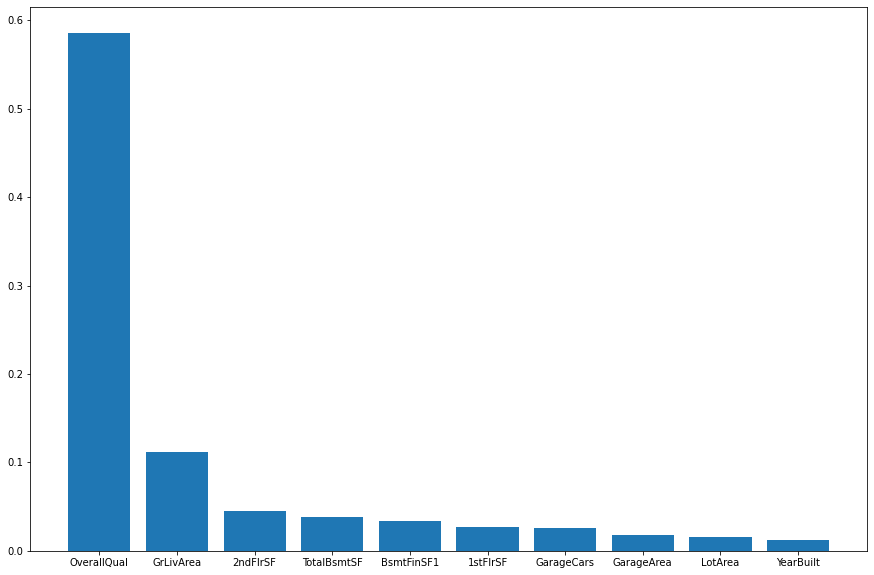

In [23]:
labels_num = show_feature_importance(rf, X_numeric)

Создадим функцию заполнения пропусков

In [24]:
def fill_nan(df, mode = "median"):
    if mode == 'low':
        fill = df.min() - df.std()
        return df.fillna(fill)
    elif mode == 'high':
        fill = df.min() - df.std()
        return df.fillna(fill)
    else:
        return df.fillna(df.agg(mode))

In [26]:
for mode in ["low", 'high', 'median', 'mean', 'max', 'min']:
    rf = RandomForestRegressor(max_depth = 8)
    new_train  = fill_nan(X_train[numeric_cols], mode = mode)
    res = cross_val_score(rf,new_train , y_train, cv = 5, scoring = 'neg_mean_squared_log_error')
    print(mode, res.mean(), res.std())

low -0.023650156183884614 0.0018902416445949334
high -0.024002082241623313 0.0018622845509597352
median -0.023930289343078927 0.002362936841481451
mean -0.0238109928737688 0.0025360422289408555
max -0.02340211482305902 0.0025899466889116713
min -0.02413073653141868 0.0021557363485842657


Лучше всего заполнять медианой или средним

In [75]:
X_categorical.fillna('nan', inplace = True)
test_cat.fillna('nan', inplace = True)

Пронумеруем категориальные признаки согласно среднему значению "SalePrice" для каждой категории

In [76]:
d_cat = {}

for c in categorical_cols:
    group = train.groupby(c)["SalePrice"].mean()
    group = group.sort_values(ascending = True)
    
    arr = [x for x in group.index]
    val = [x + 1 for x in range(len(arr))]
    d_cat[c] =  {x : y for x, y in zip(arr, val)}
    X_categorical[c] = X_categorical[c].map(d_cat[c])
    test_cat[c] = test_cat[c].map(d_cat[c])

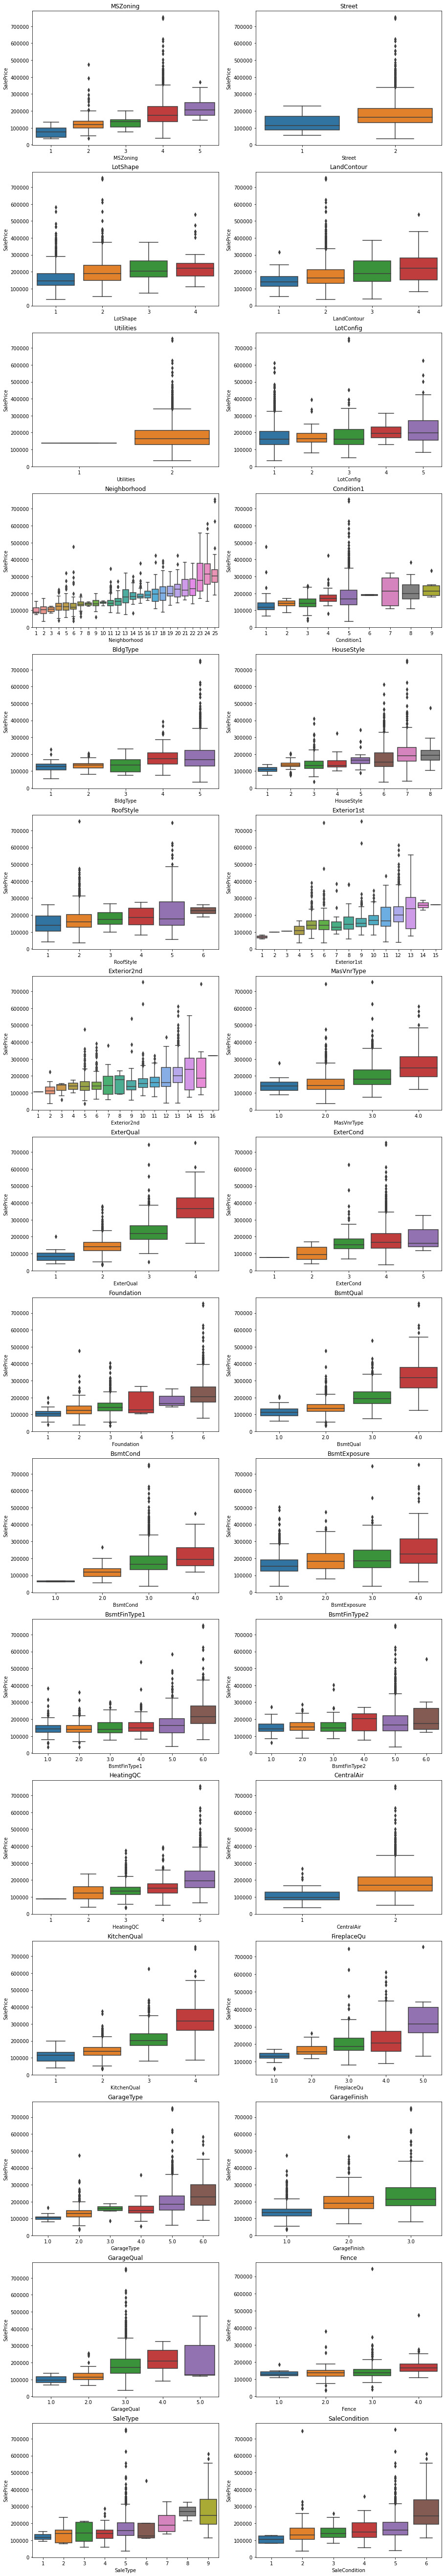

In [124]:
plt.figure(figsize = (15, 108))
count = 1

for c in X_categorical.columns:
    plt.subplot(18,2, count)
    sns.boxplot(x = X_categorical[c],
              y = train['SalePrice'])
    count += 1
    plt.title(c)

plt.show()

In [30]:
rf = RandomForestRegressor(max_depth = 10)
res = cross_val_score(rf, X_categorical.fillna(X_categorical.mean()), y_train, cv = 5, scoring = "neg_mean_squared_log_error")

In [31]:
np.sqrt(-res.mean())

0.18909472986991438

In [32]:
rf = RandomForestRegressor(max_depth = 10)
rf.fit(X_numeric.fillna(X_numeric.median()), y_train)


RandomForestRegressor(max_depth=10)

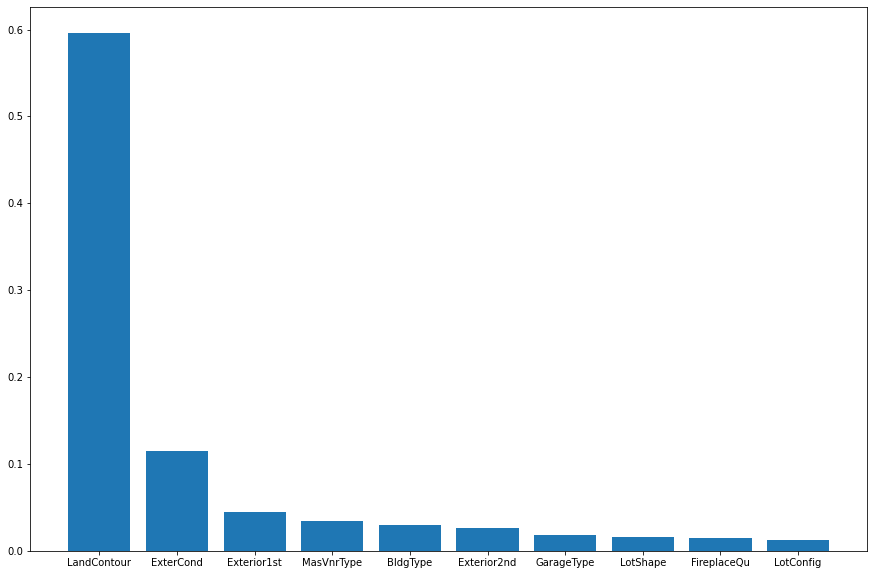

In [33]:
labels_cat = show_feature_importance(rf, X_categorical)

In [1]:
new_train = pd.concat([X_numeric, X_categorical], axis = 1)
new_test = pd.concat([test_num, test_cat], axis = 1)

NameError: name 'pd' is not defined

In [ ]:
new_train.head()

Сделаем промтейший перебор

In [36]:
rf = RandomForestRegressor(max_depth=10)
res = cross_val_score(rf, new_train.fillna(new_train.mean()).values, y_train.values, cv = 5, scoring = "neg_mean_squared_log_error")

In [112]:
grid = GridSearchCV(RandomForestRegressor(), {'criterion' : ['mse', 'mae'], 'max_depth' : [8, 12, 20], 
                                             'min_impurity_decrease' : [1e-5, 1e-4, 1e-3]}, 
                                            scoring = "neg_mean_squared_log_error", cv = 5, n_jobs= - 1, verbose = 4)

In [113]:
grid.fit(new_train.fillna(new_train.median()), y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.8min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [8, 12, 20],
                         'min_impurity_decrease': [1e-05, 0.0001, 0.001]},
             scoring='neg_mean_squared_log_error', verbose=4)

In [114]:
grid.best_estimator_

RandomForestRegressor(max_depth=12, min_impurity_decrease=0.0001)

In [117]:
grid.cv_results_

{'mean_fit_time': array([ 0.80798173,  0.79878016,  0.79737945,  1.08244362,  1.09424644,
         1.06163888,  1.19666953,  1.18226628,  1.17606459, 10.913658  ,
        10.97807226, 10.99907718, 12.5876348 , 12.70266075, 12.79108081,
        13.28019109, 13.31739941, 13.09460478]),
 'std_fit_time': array([0.01975678, 0.00954373, 0.01063061, 0.01022768, 0.01432803,
        0.01255051, 0.0103288 , 0.01112008, 0.007196  , 0.07507275,
        0.10026556, 0.03341164, 0.11791348, 0.14288502, 0.06324858,
        0.08153755, 0.18792458, 0.23140259]),
 'mean_score_time': array([0.00940213, 0.00900192, 0.00840192, 0.01000233, 0.01020226,
        0.01040235, 0.01120253, 0.01060247, 0.01060243, 0.00880218,
        0.00820198, 0.00820208, 0.01000237, 0.00980225, 0.01000242,
        0.01100245, 0.01080251, 0.01040235]),
 'std_score_time': array([1.02021629e-03, 1.09562694e-03, 4.90037718e-04, 6.32635932e-04,
        4.00257139e-04, 4.90057117e-04, 4.00090370e-04, 8.00251966e-04,
        4.90037694

In [116]:
np.sqrt( - grid.best_score_)

0.14270136405975908

Посмотрим как влияет количество признаков на качество

In [99]:

def RFE_feature_selection(clf_lr, X, y,scoring='neg_mean_squared_error'):
    rfecv = RFECV(estimator=clf_lr, step=1, verbose=10, scoring='neg_mean_squared_error', cv = 5, n_jobs=4, min_features_to_select=3)
    rfecv.fit(X, y)

    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    f, ax = plt.subplots(figsize=(16, 9))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.grid(True)
    plt.show()
    return rfecv.ranking_


Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Optimal number of features : 55


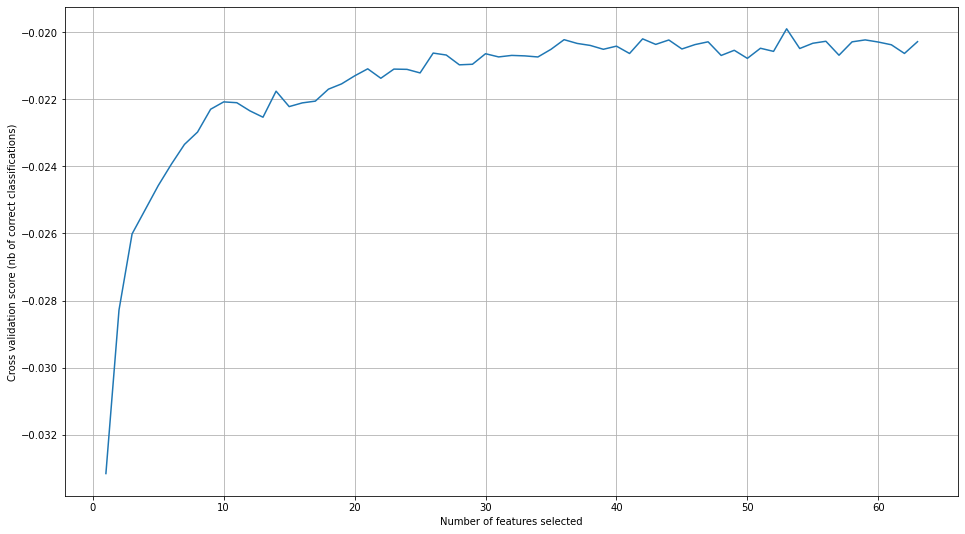

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  9,  1,  1,
        8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  1,  1,  1,
       11,  1,  1, 10,  1,  1,  1,  4,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        2,  1,  1,  5,  1,  1,  1,  1,  1,  1,  7,  6,  1,  1])

In [44]:

RFE_feature_selection(grid.best_estimator_, new_train.fillna(new_train.median()), y_train)

In [82]:
rf = RandomForestRegressor(max_depth=20, min_impurity_decrease=0.001)
rf.fit(new_train.fillna(new_train.median()).values, y_train.values)

RandomForestRegressor(max_depth=20, min_impurity_decrease=0.001)

In [89]:
test["SalePrice"] = rf.predict(new_test.fillna(new_train.median()))

In [96]:
test[["SalePrice"]].to_csv('sub2.csv')

In [105]:
from sklearn.preprocessing import RobustScaler

In [106]:
new_train_scaled = RobustScaler().fit_transform(new_train)
new_train_scaled = pd.DataFrame(new_train, columns = new_train.columns)

In [107]:
rf = RandomForestRegressor(max_depth=20, min_impurity_decrease=0.001)
res = cross_val_score(rf, new_train.fillna(new_train_scaled.mean()).values, y_train.values, cv = 5, scoring = "neg_mean_squared_log_error")

In [110]:
np.sqrt(-res.mean())

0.14359445845195973